# AIRDOS 

In [29]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import matplotlib.pyplot as plt

import plotly.plotly as py
import plotly.graph_objs as go

In [30]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


## Read Logfile

In [31]:
fto = './data/DATALOG.TXT' #  File to Open
l=[]
l.extend(range(0,520))
df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='python')

#
''' DEBUG
df = df.reset_index(drop=True)
df.drop(df[df.index > 100].index, inplace=True)
'''#'''

df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
#df.drop(r[r[0]=='$GPRMC'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
df.drop(df[df[0]=='$GPGSV'].index, inplace=True)
#df.drop(df[df[0]=='$CANDY'].index, inplace=True)

# Convert strings to numbers
#df = df.apply(pd.to_numeric, errors='ignore')

#df.iloc[:,0:13]

#df

## Plot Flux

In [32]:
date = np.nan #pd.to_datetime('210317000000.00', format='%d%m%y%H%M%S.%f')
altitude = np.nan
LatDD = np.nan
LonDD = np.nan
speed = np.nan
flag=0

for i,r in df.iterrows():
    if (r[0] == '$GPRMC'):
        date = pd.to_datetime(str(r[9])+str(r[1]), format='%d%m%y%H%M%S.%f',errors='coerce')
        flag = 1
        speed = r[7]
        
    if (r[0] == '$GPGGA'):
        altitude = r[9]

    df.set_value(i,'date',date)
    #df.set_value(i,'altitude',np.nan)
    df.set_value(i,'altitude',altitude)
    df.set_value(i,'speed',speed)

    if (r[0] == '$CANDY'):
        date = date + pd.Timedelta(seconds=14)
        df.set_value(i,'date',date)
        #if (flag==1):
        #    df.set_value(i,'altitude',altitude)
        #    flag=0
        
dfo = df
#dfo.reset_index(inplace=True)
dfo.drop(dfo[dfo[0]=='$GPRMC'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$GPGGA'].index, inplace=True)

dfo.to_csv('radiation.csv')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view

"flux to file\nxxx = pd.DataFrame()\nxxx = xx[['altitude','flux','speed']]\nxxx.to_csv('flux.csv')\n#"

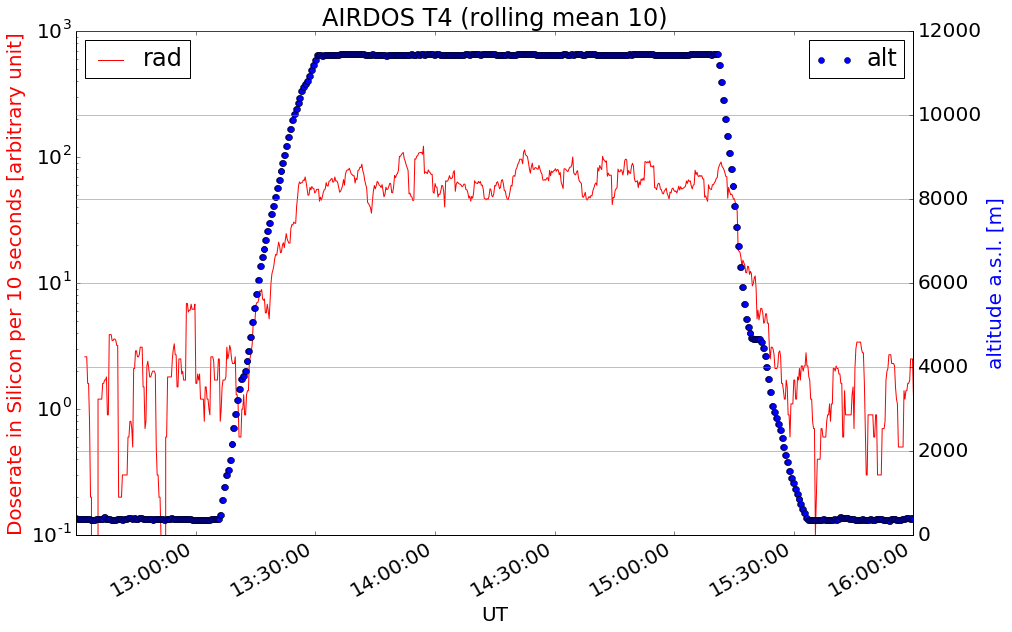

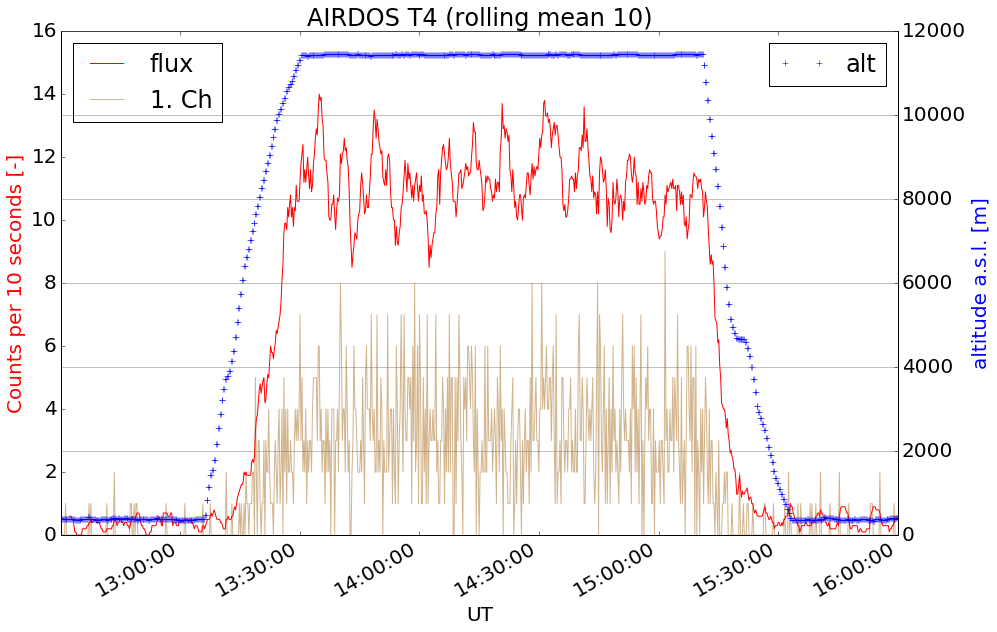

In [33]:
#DeviceName = 'AIRDOS A005'
DeviceName = 'AIRDOS T4'
plt.figure(figsize=(15,10))
matplotlib.rcParams.update({'font.size': 15})

dfo = pd.read_table('radiation.csv', sep=',', header=0)
#dfo = dfo.dropna(how='any')
dfo = dfo.dropna(subset=['date'])
dfo['date'] = pd.to_datetime(dfo['date'])
dfo = dfo.set_index(['date'])
#xx = dfo.loc['2018-01-03 17:00:00':]
#xx = dfo.loc['2018-06-23 11:00:00':'2018-06-27 10:00:00']
xx = dfo.loc['2017-11-29 12:30:00':'2017-11-29 16:00:00']
#xx = dfo
#pandas.rolling_mean(arg, window, min_periods=None, freq=None, center=False, how=None, **kwargs)

NOISE_LEVEL=261
LAST_CHANNEL=515
xx['flux'] = xx[range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1)
xx['highflux'] = xx[range(NOISE_LEVEL+20,LAST_CHANNEL)].sum(axis=1)
xx[range(NOISE_LEVEL,LAST_CHANNEL)] = xx[range(NOISE_LEVEL,LAST_CHANNEL)].mul(range(1,LAST_CHANNEL+1-NOISE_LEVEL),axis=1)
xx['rad'] = xx[range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1)

WINDOW = 10
xx['rad'] = pd.rolling_mean(xx['rad'],WINDOW)
xx['flux'] = pd.rolling_mean(xx['flux'],WINDOW)
xx['highflux'] = pd.rolling_mean(xx['highflux'],WINDOW)
#xx['altitude'] = pd.rolling_mean(xx['altitude'],WINDOW)

#xx['rad'].plot(c='r', label='Doserate (rolling mean '+str(WINDOW)+')')
xx['rad'].plot(c='red')
plt.yscale('log')

plt.xlabel('UT')
plt.ylabel('Doserate in Silicon per 10 seconds [arbitrary unit]', color='red')
#, xticks=['2017-03-27 00:00','2017-03-27 12:00','2017-03-28 00:00','2017-03-28 12:00','2017-03-29 00:00'],figsize=(20,5))
plt.legend(loc=2)

ax = plt.twinx()

xx['altitude'].plot(c='b', label='alt', marker='o', linewidth='5', linestyle='None')
plt.ylabel('altitude a.s.l. [m]', color='blue')
#plt.ylim([0,500])
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()
plt.title(DeviceName + ' (rolling mean ' + str(WINDOW) + ')')
plt.figure(figsize=(15,10))
matplotlib.rcParams.update({'font.size': 20})

xx['flux'].plot(c='red')
plt.ylim([0,16])

plt.plot(xx.iloc[:,NOISE_LEVEL],c='tan',label='1. Ch',zorder=1)
plt.xlabel('UT')
plt.ylabel('Counts per 10 seconds [-]', color='red')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([11400,11460])
xx['altitude'].plot(c='b', label='alt', marker='+', linewidth='2', linestyle='none', drawstyle='steps-mid')
#xx['altitude'].plot(c='b', label='alt', linewidth='1')
plt.ylabel('altitude a.s.l. [m]', color='blue')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()
plt.title(DeviceName + ' (rolling mean ' + str(WINDOW) + ')')

#
'''flux to file
xxx = pd.DataFrame()
xxx = xx[['altitude','flux','speed']]
xxx.to_csv('flux.csv')
#'''

In [71]:
import plotly.plotly as py
#import numpy as np

data = [dict(
        visible = False,
        line=dict(color='00CED1', width=6),
        name = '𝜈 = '+str(step),
        x = np.arange(0,10,0.01),
        y = np.sin(step*np.arange(0,10,0.01))) for step in np.arange(0,5,0.1)]
data[10]['visible'] = True

steps = []
for i in range(len(data)):
    step = dict(
        method = 'restyle',
        args = ['visible', [False] * len(data)],
    )
    step['args'][1][i] = True # Toggle i'th trace to "visible"
    steps.append(step)

fig = dict(data=data)

py.iplot(fig, filename='Sine Wave Slider')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~martin.kakona/0 or inside your plot.ly account where it is named 'Sine Wave Slider'


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view

"flux to file\nxxx = pd.DataFrame()\nxxx = xx[['altitude','flux','speed']]\nxxx.to_csv('flux.csv')\n#"

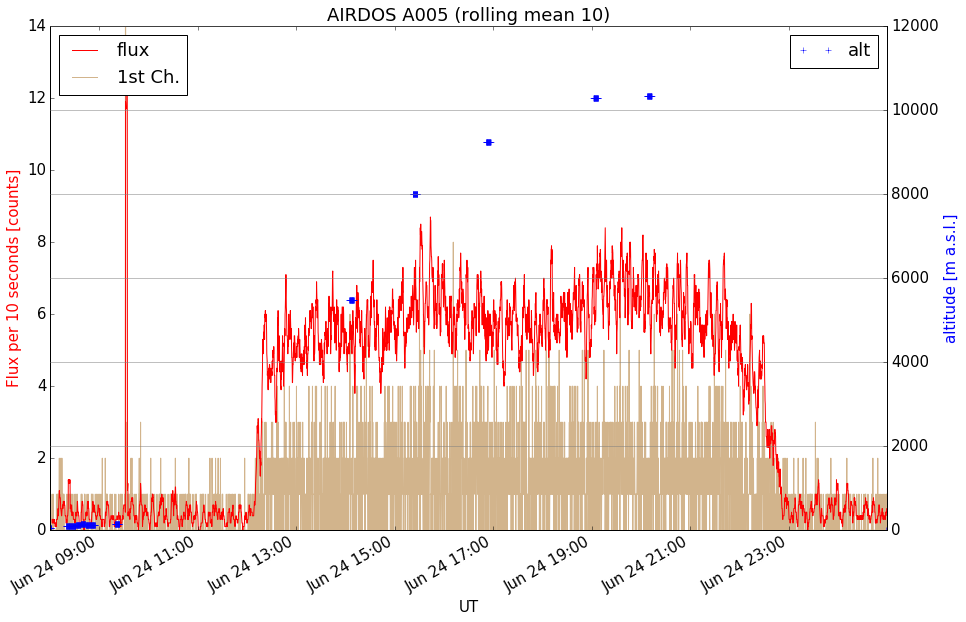

In [92]:
from matplotlib import dates
    
DeviceName = 'AIRDOS A005'
#DeviceName = 'AIRDOS T4'
plt.figure(figsize=(15,10))
matplotlib.rcParams.update({'font.size': 15})

dfo = pd.read_table('radiation.csv', sep=',', header=0)
#dfo = dfo.dropna(how='any')
dfo = dfo.dropna(subset=['date'])
dfo['date'] = pd.to_datetime(dfo['date'])
dfo = dfo.set_index(['date'])
#xx = dfo.loc['2018-01-03 17:00:00':]
xx = dfo.loc['2018-06-24 08:00:00':'2018-06-25 01:00:00']
#xx = dfo.loc['2018-06-26 11:00:00':'2018-06-27 04:00:00']
#xx = dfo
#pandas.rolling_mean(arg, window, min_periods=None, freq=None, center=False, how=None, **kwargs)

NOISE_LEVEL=269
LAST_CHANNEL=515
xx['flux'] = xx[range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1)
#xx['highflux'] = xx[range(NOISE_LEVEL+20,LAST_CHANNEL)].sum(axis=1)
xx[range(NOISE_LEVEL,LAST_CHANNEL)] = xx[range(NOISE_LEVEL,LAST_CHANNEL)].mul(range(1,LAST_CHANNEL+1-NOISE_LEVEL),axis=1)
xx['rad'] = xx[range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1)

WINDOW = 10
xx['rad'] = pd.rolling_mean(xx['rad'],WINDOW)
xx['flux'] = pd.rolling_mean(xx['flux'],WINDOW)
#xx['highflux'] = pd.rolling_mean(xx['highflux'],WINDOW)
#xx['altitude'] = pd.rolling_mean(xx['altitude'],WINDOW)


'''
#xx['rad'].plot(c='r', label='Doserate (rolling mean '+str(WINDOW)+')')
xx['rad'].plot(c='red')
plt.yscale('log')

plt.xlabel('UT')
plt.ylabel('Doserate in Silicon per 10 seconds [arbitrary unit]', color='red')
#, xticks=['2017-03-24 00:00','2017-03-24 12:00','2017-03-25 00:00','2017-03-25 12:00','2017-03-26 00:00'],figsize=(20,5))
plt.legend(loc=2)

ax = plt.twinx()

xx['altitude'].plot(c='b', label='alt', marker='o', linewidth='5', linestyle='None')
plt.ylabel('altitude a.s.l. [m]', color='blue')
#plt.ylim([0,500])
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()
plt.title(DeviceName + ' (rolling mean ' + str(WINDOW) + ')')
plt.figure(figsize=(15,10))
matplotlib.rcParams.update({'font.size': 20})
'''

xx['flux'].plot(c='red')
plt.ylim([0,14])

plt.plot(xx.iloc[:,NOISE_LEVEL],c='tan',label='1st Ch.',zorder=1)
plt.xlabel('UT')
plt.ylabel('Flux per 10 seconds [counts]', color='red')
plt.legend(loc=2)

ax = plt.twinx()

dfmt = dates.DateFormatter('%b %d %H:%M')
ax.xaxis.set_major_formatter(dfmt)

#plt.ylim([11400,11460])
xx['altitude'].plot(c='b', label='alt', marker='+', linewidth='2', linestyle='none', drawstyle='steps-mid')
#xx['altitude'].plot(c='b', label='alt', linewidth='1')
plt.ylabel('altitude a.s.l. [m]', color='blue')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()
plt.title(DeviceName + ' (rolling mean ' + str(WINDOW) + ')')


#
'''flux to file
xxx = pd.DataFrame()
xxx = xx[['altitude','flux','speed']]
xxx.to_csv('flux.csv')
#'''

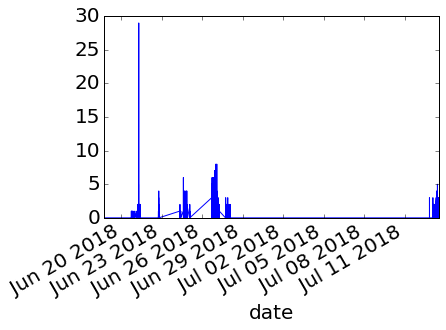

In [31]:
#xx.iloc[100:110,260:]
dfo['268'].plot()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:23: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,center=False).mean()


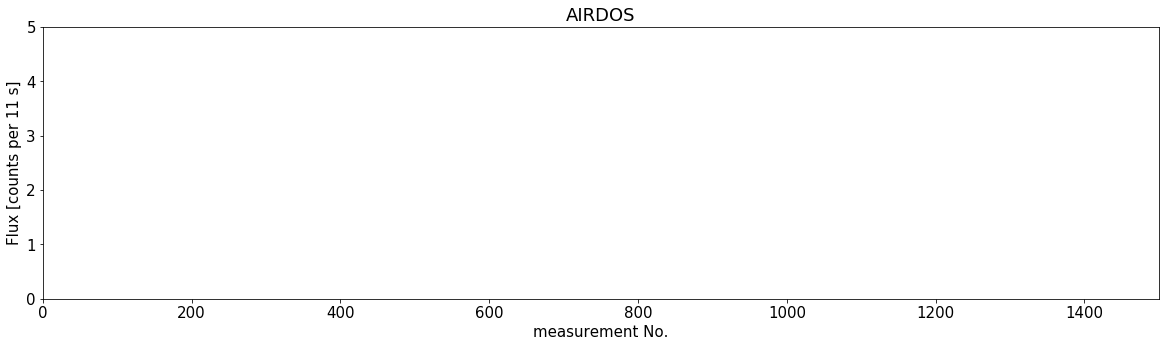

In [9]:
rc = df.loc[df[0]=='$CANDY']
rc.reset_index(drop=True, inplace=True)

rc = rc.apply(pd.to_numeric, errors='coerce')

#rc.to_csv('ble.txt')

#rc['sum'] = rc[range(24,544)].sum(axis=1)
#rc['sum'] = rc[range(21,544)].sum(axis=1)
#rc['sum']


plt.figure(figsize=(20,5))
plt.ylim([0,5])
NOISE_LEVEL=21
xx = rc.ix[:]
NOISE_LEVEL=260
LAST_CHANNEL=514
#xx[range(NOISE_LEVEL,LAST_CHANNEL)] = xx[range(NOISE_LEVEL,LAST_CHANNEL)].mul(range(1,LAST_CHANNEL+1-NOISE_LEVEL),axis=1)
xx['rad'] = xx[range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1)

WINDOW = 30
xx['rad'] = pd.rolling_mean(xx['rad'],WINDOW)
xx['rad'].plot(c='b')

plt.title('AIRDOS')
plt.xlabel('measurement No.')
plt.ylabel('Flux [counts per 11 s]')

In [95]:
# rc.iloc[:,516:1025]
#dfo.iloc[:,516:1025]
#dfo.reset_index(drop=True, inplace=True)
#dfo.iloc[:,500:]
#xx.iloc[:,260:515]
#dfo[range(260,514)]
#df6
#print NOISE_LEVEL
xx.iloc[:20,268]
#xx[['flux','altitude']]


date
2018-06-24 08:00:08    14
2018-06-24 08:00:22    10
2018-06-24 08:00:36     2
2018-06-24 08:00:50     9
2018-06-24 08:01:04     9
2018-06-24 08:01:25    21
2018-06-24 08:01:39    16
2018-06-24 08:01:53     6
2018-06-24 08:02:07    17
2018-06-24 08:02:21    15
2018-06-24 08:02:35    13
2018-06-24 08:02:49    12
2018-06-24 08:03:03    17
2018-06-24 08:03:17     8
2018-06-24 08:03:31    11
2018-06-24 08:03:45    13
2018-06-24 08:03:59     8
2018-06-24 08:04:13    13
2018-06-24 08:04:27     8
2018-06-24 08:04:41    16
Name: 267, dtype: float64

# ------------------------------------------------------------------------------------

## Concatenate RMC and GGA lines to one table

In [97]:
df = df.reset_index(drop=True)
df1 = df.loc[df[0]=='$GPRMC']
df1 = df1.iloc[:,0:12]
df2 = df.iloc[df.loc[df[0]=='$GPRMC'].index+1]
df2 = df2.iloc[:,0:15]
df1 = df1.reset_index(drop=True)
df2 = df2.reset_index(drop=True)
df5 = pd.concat([df1,df2], axis=1,  ignore_index=True)
# Convert NMEA time to pandas time
df5[9] = df5[9].astype(str)
df5[1] = df5[1].astype(str)
df5[1] = pd.to_datetime(df5[9]+df5[1], format='%d%m%y%H%M%S.%f',errors='coerce')#.dt.time
#df5=df5.rename(columns = {2:'time'})#
#df5 = df5.iloc[:,0:20]

df5.drop(df5[df5[24]!='M'].index, inplace=True)

df5[21] = pd.to_numeric(df5[21],errors='coerce')

df6 = pd.DataFrame()
df6['time']=df5[1]
df6['altitude'] = df5[21]
df6['Lat'] = df5[3]
df6['Lats'] = df5[4]
df6['Lon'] = df5[5]
df6['Lons'] = df5[6]
df6['time'] = pd.to_datetime(df6.time)
df6.set_index('time', inplace=True)
df6.dropna(axis=0,inplace=True)
df6 = df6[pd.notnull(df6.index)]
df6.to_csv('./data/ble.txt')
#df6.iloc[50:100]

## Convert Grades/Minutes to Grades

In [98]:
df6['Lat'] = df6['Lat'].astype(float)
df6['Lon'] = df6['Lon'].astype(float)

df6['Lats'] = df6['Lats'].str.replace('N','1')
df6['Lats'] = df6['Lats'].str.replace('S','-1')
df6['Lons'] = df6['Lons'].str.replace('E','1')
df6['Lons'] = df6['Lons'].str.replace('W','-1')

df6['LatDD'] = (df6.Lat/100).fillna(0).astype(int)
df6['LatDD'] = df6.LatDD + (df6.Lat - 100.0*df6.LatDD)/60.0
df6['LatDD'] = df6.LatDD * df6['Lats'].astype(float)  


df6['LonDD'] = (df6.Lon/100).fillna(0).astype(int)
df6['LonDD'] = df6.LonDD + (df6.Lon - 100.0*df6.LonDD)/60.0
df6['LonDD'] = df6.LonDD * df6['Lons'].astype(float)  

## Plot Map

In [99]:
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import urllib, os

plt.figure(figsize=(15,15))
matplotlib.rcParams.update({'font.size': 15})


# draw map with markers for float locations
#m = Basemap(projection='kav7',lon_0=0)

# World map
m = Basemap(llcrnrlon=-20,llcrnrlat=30,urcrnrlon=180,urcrnrlat=80,projection='mill')

# Detailed map
#m = Basemap(llcrnrlon=14,llcrnrlat=50,urcrnrlon=17,urcrnrlat=51, epsg = 31284,resolution='i',projection='merc')
#m.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 800, verbose= True)

x, y = m(df6.LonDD.tolist(),df6.LatDD.tolist())
m.drawmapboundary(fill_color='#99ffff')
m.fillcontinents(color='#cc9966',lake_color='#99ffff',zorder=0)
# draw parallels and meridians, but don't bother labelling them.
#m.drawparallels(np.arange(-90.,99.,30.),labels=[1,1,0,0])
#m.drawmeridians(np.arange(-180.,180.,60.),labels=[0,0,1,0])
m.drawparallels(np.arange(-90.,99.,10.),labels=[1,1,0,0])
m.drawmeridians(np.arange(-180.,180.,10.),labels=[0,0,1,0])
#m.scatter(df6.LonDD.tolist(),df6.LatDD.tolist(),3,marker='o',color='r')
im1 = m.scatter(x,y,c=df6.altitude.tolist(),s=7,marker='o',  linewidth='3', cmap='jet')
cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
cb.set_label('m a.s.l.')
plt.show()

ImportError: No module named basemap

In [128]:
#df = df6
df = df6.loc['2018-06-24 08:00:00':'2018-06-25 01:00:00']
#df = df6.loc['2018-06-26 11:00:00':'2018-06-27 04:00:00']


df['text'] = df['altitude']

scl = 'Rainbow'

data = [ dict(
        type = 'scattergeo',
        locationmode = 'asia',
    
        lon = df.LonDD,
        lat = df.LatDD,
        text = df['text'],
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = False,
            autocolorscale = False,
            symbol = 'dot',
            #line = dict(width=1, color='rgba(102, 102, 102)'),
            colorscale = scl,
            cmin = 0,
            color = df.altitude,
            cmax = df.altitude.max(),
            colorbar=dict(
                title="Altitude"
            )
        ))]

layout = dict(
        title = 'AIRDOS A005',
        colorbar = True,
        geo = dict(
            scope='world',
            projection=dict( type='Mercator' ),
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='AIRDOS-map' )

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/lib/python2.7/dist-packages/pandas/core/frame.py:2320: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

"flux to file\nxxx = pd.DataFrame()\nxxx = xx[['altitude','flux','speed']]\nxxx.to_csv('flux.csv')\n#"

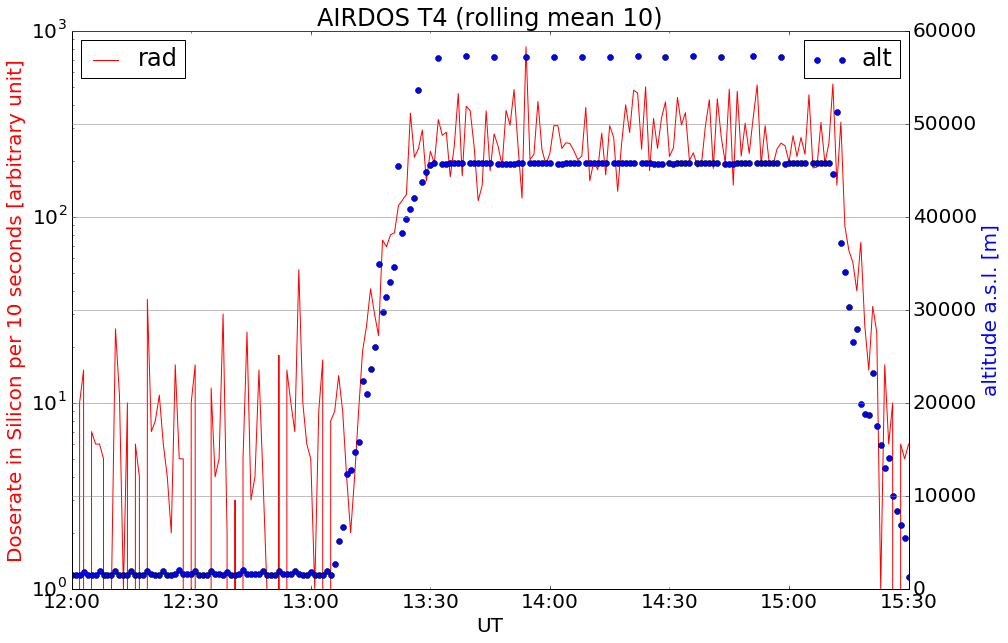

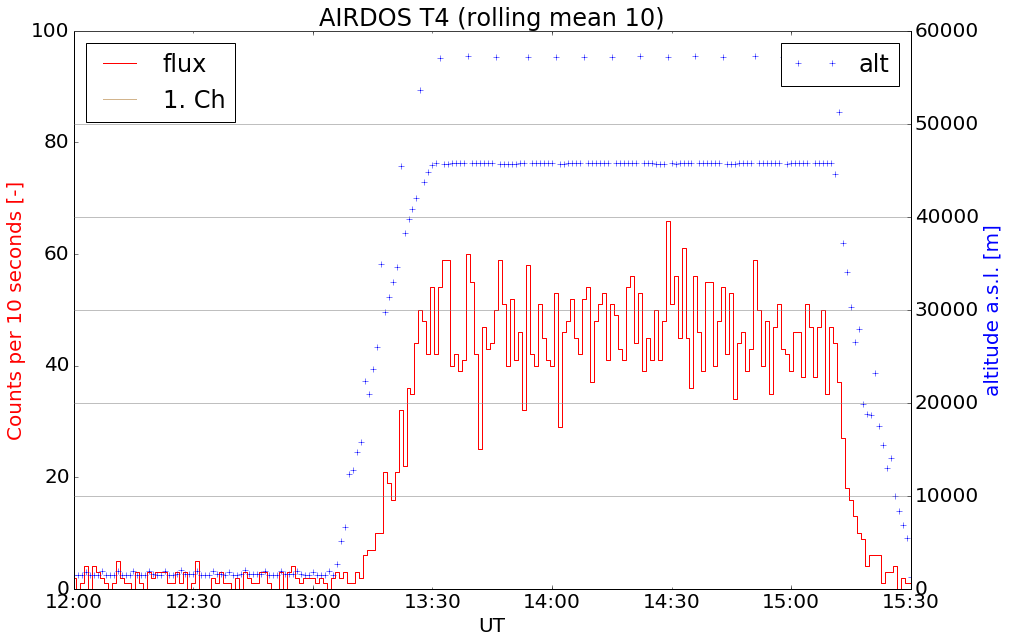

In [18]:
#DeviceName = 'AIRDOS A005'
DeviceName = 'AIRDOS T4'
plt.figure(figsize=(15,10))
matplotlib.rcParams.update({'font.size': 15})

dfo = pd.read_table('radiation.csv', sep=',', header=0)
#dfo = dfo.dropna(how='any')
dfo = dfo.dropna(subset=['date'])
dfo['date'] = pd.to_datetime(dfo['date'])
dfo = dfo.set_index(['date'])
#xx = dfo.loc['2018-01-03 17:00:00':]
xx = dfo.loc['2017-11-29 12:30:00':'2017-11-29 15:30:00']
#xx = dfo
#pandas.rolling_mean(arg, window, min_periods=None, freq=None, center=False, how=None, **kwargs)

NOISE_LEVEL=261
LAST_CHANNEL=515
xx['flux'] = xx[range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1)
xx['highflux'] = xx[range(NOISE_LEVEL+20,LAST_CHANNEL)].sum(axis=1)
xx[range(NOISE_LEVEL,LAST_CHANNEL)] = xx[range(NOISE_LEVEL,LAST_CHANNEL)].mul(range(1,LAST_CHANNEL+1-NOISE_LEVEL),axis=1)
xx['rad'] = xx[range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1)

sample = '1 min'
method = 'sum'
xx = xx.resample(sample, how=method)


#xx['rad'].plot(c='r', label='Doserate (rolling mean '+str(WINDOW)+')')
xx['rad'].plot(c='red')
plt.yscale('log')

plt.xlabel('UT')
plt.ylabel('Doserate in Silicon per 10 seconds [arbitrary unit]', color='red')
#, xticks=['2017-03-27 00:00','2017-03-27 12:00','2017-03-28 00:00','2017-03-28 12:00','2017-03-29 00:00'],figsize=(20,5))
plt.legend(loc=2)

ax = plt.twinx()

xx['altitude'].plot(c='b', label='alt', marker='o', linewidth='5', linestyle='None')
plt.ylabel('altitude a.s.l. [m]', color='blue')
#plt.ylim([0,500])
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()
plt.title(DeviceName + ' (rolling mean ' + str(WINDOW) + ')')
plt.figure(figsize=(15,10))
matplotlib.rcParams.update({'font.size': 20})

xx['flux'].plot(c='red', drawstyle='steps-mid')
plt.ylim([0,100])

plt.plot(xx.iloc[:,NOISE_LEVEL],c='tan',label='1. Ch',zorder=1)
plt.xlabel('UT')
plt.ylabel('Counts per 10 seconds [-]', color='red')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([11400,11460])
xx['altitude'].plot(c='b', label='alt', marker='+', linewidth='2', linestyle='none', drawstyle='steps-mid')
#xx['altitude'].plot(c='b', label='alt', linewidth='1')
plt.ylabel('altitude a.s.l. [m]', color='blue')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()
plt.title(DeviceName + ' (rolling mean ' + str(WINDOW) + ')')

#
'''flux to file
xxx = pd.DataFrame()
xxx = xx[['altitude','flux','speed']]
xxx.to_csv('flux.csv')
#'''